In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from nancorrmp.nancorrmp import NaNCorrMp
from analysis.hierarchical import get_clust_graph, sp_hier

def fit_hier_group(mode, task='rest'):
    mice.setup_func_data(task)
    proc, *_ = mice.get_data_containers(mode)

    adj_pears = []
    adj_spear = []
    for key, func in tqdm(proc.items()):
        if mice.looper[key][-1] < 0:
            continue

        base = Base(mice, key=key, mode=mode, task=task)

        a, p = NaNCorrMp.calculate_with_p_value(base.data)
        a[p > 0.05] = np.nan
        adj_pears.append(np.expand_dims(a, 0))

        a, p = sp_stats.spearmanr(base.data, axis=1)
        a[p > 0.05] = np.nan
        adj_spear.append(np.expand_dims(a, 0))

    adj_pears = np.concatenate(adj_pears)
    adj_pears = bn.nanmean(adj_pears, 0)
    adj_spear = np.concatenate(adj_spear)
    adj_spear = bn.nanmean(adj_spear, 0)

    for i in range(len(adj_pears)):
        nans = np.isnan(adj_pears[i])
        adj_pears[i][nans] = bn.nanmean(adj_pears[i])

    for i in range(len(adj_spear)):
        nans = np.isnan(adj_spear[i])
        adj_spear[i][nans] = bn.nanmean(adj_spear[i])

    a_sym = (adj_pears + adj_pears.T) / 2
    d_pears = 1 - a_sym

    a_sym = (adj_spear + adj_spear.T) / 2
    d_spear = 1 - a_sym
    
    z_pears = sp_hier.linkage(
        sp_dist.squareform(d_pears),
        method='ward',
        metric='correlation',
        optimal_ordering=True,
    )
    result = get_clust_graph(
        linkage_mat=z_pears,
        labels=base.l2n,
        num_clusters=5,
    )
    comm_vec = np.zeros(len(base.n2l))
    for c_idx, clist in result['cluster_assigns'].items():
        for lbl in clist:
            comm_vec[base.l2n[lbl]] = c_idx
    proj_pears = base.project_vec(comm_vec)

    z_spear = sp_hier.linkage(
        sp_dist.squareform(d_spear),
        method='ward',
        metric='correlation',
        optimal_ordering=True,
    )
    result = get_clust_graph(
        linkage_mat=z_spear,
        labels=base.l2n,
        num_clusters=5,
    )
    comm_vec = np.zeros(len(base.n2l))
    for c_idx, clist in result['cluster_assigns'].items():
        for lbl in clist:
            comm_vec[base.l2n[lbl]] = c_idx
    proj_spear = base.project_vec(comm_vec)
    
    output = {
        'd_pears': d_pears,
        'd_spear': d_spear,
        'proj_pears': proj_pears,
        'proj_spear': proj_spear,
    }
    return output

In [3]:
%%time

mice = Mice((192, 4))

CPU times: user 247 ms, sys: 710 ms, total: 957 ms
Wall time: 956 ms


In [17]:
ca2_rest = fit_hier_group('ca2', 'rest')
bold_rest = fit_hier_group('bold-lite', 'rest')

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

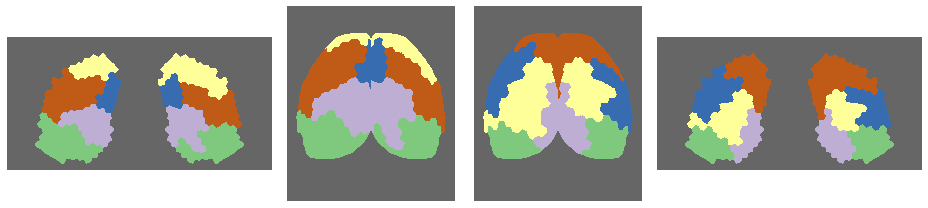

In [18]:
fig, axes = create_figure(1, 4, (13, 3), gridspec_kw={'width_ratios': [1.5, 1, 1, 1.5]})
axes[0].imshow(ca2_rest['proj_pears']['parcel2d-flat'].squeeze(), cmap='Accent_r')
axes[1].imshow(ca2_rest['proj_pears']['parcel2d-top'].squeeze(), cmap='Accent_r')
axes[2].imshow(ca2_rest['proj_spear']['parcel2d-top'].squeeze(), cmap='Accent_r')
axes[3].imshow(ca2_rest['proj_spear']['parcel2d-flat'].squeeze(), cmap='Accent_r')
remove_ticks(axes)
plt.show()

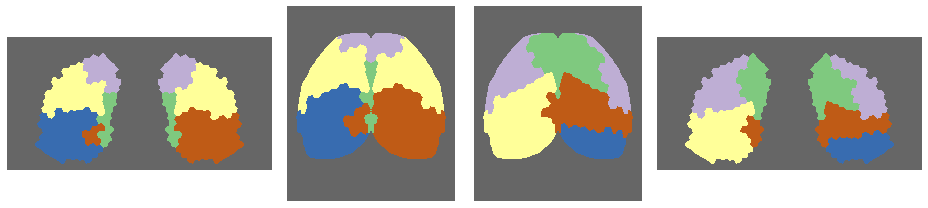

In [19]:
fig, axes = create_figure(1, 4, (13, 3), gridspec_kw={'width_ratios': [1.5, 1, 1, 1.5]})
axes[0].imshow(bold_rest['proj_pears']['parcel2d-flat'].squeeze(), cmap='Accent_r')
axes[1].imshow(bold_rest['proj_pears']['parcel2d-top'].squeeze(), cmap='Accent_r')
axes[2].imshow(bold_rest['proj_spear']['parcel2d-top'].squeeze(), cmap='Accent_r')
axes[3].imshow(bold_rest['proj_spear']['parcel2d-flat'].squeeze(), cmap='Accent_r')
remove_ticks(axes)
plt.show()

In [20]:
ca2_led = fit_hier_group('ca2', 'led')
bold_led = fit_hier_group('bold-lite', 'led')

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

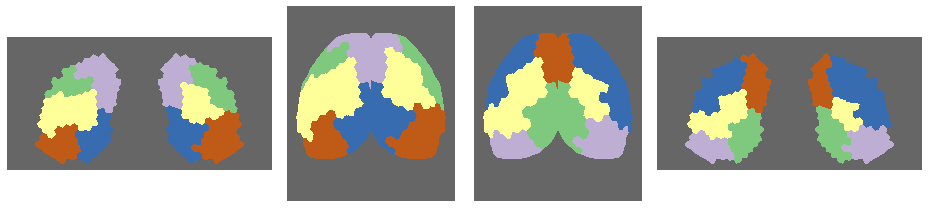

In [21]:
fig, axes = create_figure(1, 4, (13, 3), gridspec_kw={'width_ratios': [1.5, 1, 1, 1.5]})
axes[0].imshow(ca2_led['proj_pears']['parcel2d-flat'].squeeze(), cmap='Accent_r')
axes[1].imshow(ca2_led['proj_pears']['parcel2d-top'].squeeze(), cmap='Accent_r')
axes[2].imshow(ca2_led['proj_spear']['parcel2d-top'].squeeze(), cmap='Accent_r')
axes[3].imshow(ca2_led['proj_spear']['parcel2d-flat'].squeeze(), cmap='Accent_r')
remove_ticks(axes)
plt.show()

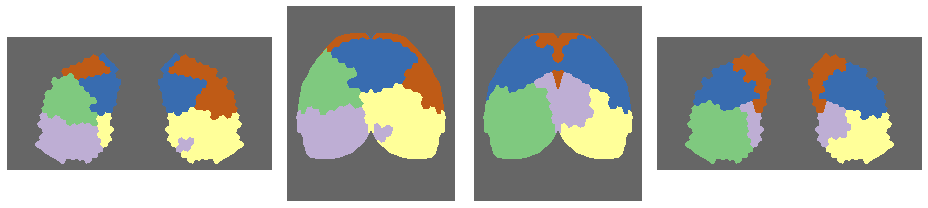

In [22]:
fig, axes = create_figure(1, 4, (13, 3), gridspec_kw={'width_ratios': [1.5, 1, 1, 1.5]})
axes[0].imshow(bold_led['proj_pears']['parcel2d-flat'].squeeze(), cmap='Accent_r')
axes[1].imshow(bold_led['proj_pears']['parcel2d-top'].squeeze(), cmap='Accent_r')
axes[2].imshow(bold_led['proj_spear']['parcel2d-top'].squeeze(), cmap='Accent_r')
axes[3].imshow(bold_led['proj_spear']['parcel2d-flat'].squeeze(), cmap='Accent_r')
remove_ticks(axes)
plt.show()

In [3]:
mice.setup_func_data()

In [4]:
num_nans = {}
adj_all = []
for key, func in tqdm(mice.ca.items()):
    if mice.looper[key][-1] < 0:
        continue
        
    base = Base(mice, key=key, mode='ca2')
    a, p = sp_stats.spearmanr(base.data, axis=1)
    a[p > 0.05] = np.nan
    adj_all.append(np.expand_dims(a, 0))
    
    num_nans[key] = (np.isnan(a).sum(0) == len(a)).sum()
    
adj_all = np.concatenate(adj_all)
adj_all = bn.nanmean(adj_all, 0)
adj_all.shape

  0%|          | 0/162 [00:00<?, ?it/s]

(302, 302)

<AxesSubplot:ylabel='Count'>

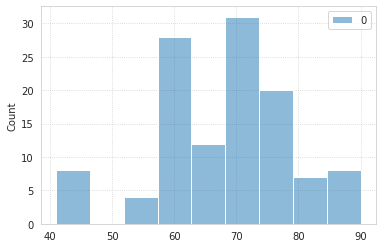

In [5]:
sns.histplot(num_nans.values())

<matplotlib.colorbar.Colorbar object at 0x7f2f0a6a1a60>

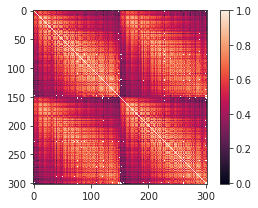

In [6]:
fig, ax = create_figure(1, 1, (4, 3))
plt.imshow(adj_all)
plt.colorbar()

In [7]:
for i in range(len(adj_all)):
    nans = np.isnan(adj_all[i])
    adj_all[i][nans] = bn.nanmean(adj_all[i])

<matplotlib.colorbar.Colorbar object at 0x7f2f0a610d60>

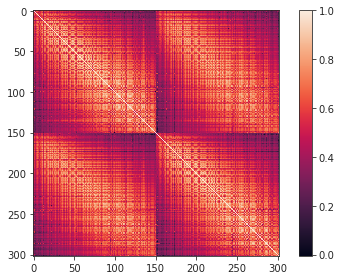

In [8]:
fig, ax = create_figure(1, 1, (6, 4))
plt.imshow(adj_all)
plt.colorbar()

In [9]:
a_sym = (adj_all + adj_all.T) / 2
d_spear_ca = 1 - a_sym

<matplotlib.colorbar.Colorbar object at 0x7f2f09d4bf40>

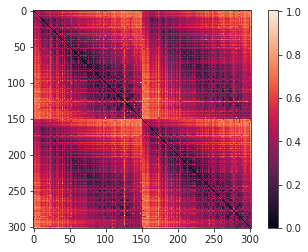

In [10]:
plt.imshow(d_spear_ca)
plt.colorbar()

In [12]:


z = sp_hier.linkage(
    sp_dist.squareform(d_spear_ca),
    method='ward',
    metric='correlation',
    optimal_ordering=True,
)
result = get_clust_graph(
    linkage_mat=z,
    labels=base.l2n,
    num_clusters=5,
)
comm_vec = np.zeros(len(base.n2l))
for c_idx, clist in result['cluster_assigns'].items():
    for lbl in clist:
        comm_vec[base.l2n[lbl]] = c_idx
        
proj_spear_ca = base.project_vec(comm_vec)

<matplotlib.image.AxesImage object at 0x7f31e3c2c580>

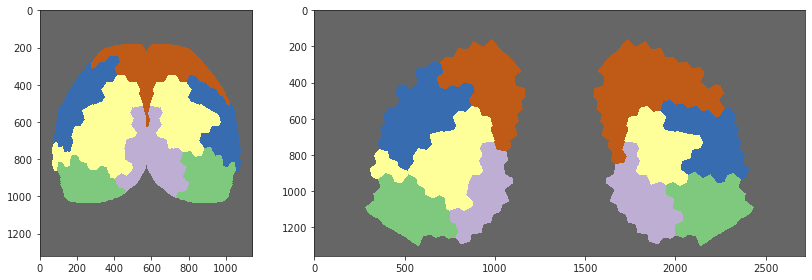

In [13]:
fig, axes = create_figure(1, 2, (13, 4))
axes[0].imshow(proj_spear_ca['parcel2d-top'].squeeze(), cmap='Accent_r')
axes[1].imshow(proj_spear_ca['parcel2d-flat'].squeeze(), cmap='Accent_r')

In [15]:
num_nans = {}
adj_all = []
for key, func in tqdm(mice.ca.items()):
    if mice.looper[key][-1] < 0:
        continue

    base = Base(mice, key=key, mode='ca2')
    a, p = NaNCorrMp.calculate_with_p_value(base.data)
    a[p > 0.05] = np.nan
    adj_all.append(np.expand_dims(a, 0))
    
    num_nans[key] = (np.isnan(a).sum(0) == len(a)).sum()

adj_all = np.concatenate(adj_all)
adj_all = bn.nanmean(adj_all, 0)

for i in range(len(adj_all)):
    nans = np.isnan(adj_all[i])
    adj_all[i][nans] = bn.nanmean(adj_all[i])

a_sym = (adj_all + adj_all.T) / 2
d_pears_ca = 1 - a_sym

  0%|          | 0/162 [00:00<?, ?it/s]

In [16]:
z = sp_hier.linkage(
    sp_dist.squareform(d_pears_ca),
    method='ward',
    metric='correlation',
    optimal_ordering=True,
)
result = get_clust_graph(
    linkage_mat=z,
    labels=base.l2n,
    num_clusters=5,
)
comm_vec = np.zeros(len(base.n2l))
for c_idx, clist in result['cluster_assigns'].items():
    for lbl in clist:
        comm_vec[base.l2n[lbl]] = c_idx
        
proj_pears_ca = base.project_vec(comm_vec)

<matplotlib.image.AxesImage object at 0x7f2ed43e53a0>

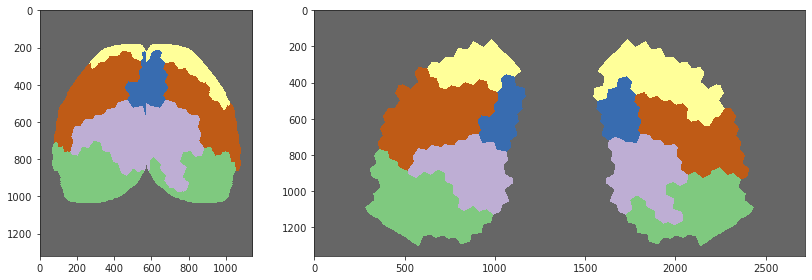

In [17]:
fig, axes = create_figure(1, 2, (13, 4))
axes[0].imshow(proj_pears_ca['parcel2d-top'].squeeze(), cmap='Accent_r')
axes[1].imshow(proj_pears_ca['parcel2d-flat'].squeeze(), cmap='Accent_r')

In [18]:
adj_pears = []
adj_spear = []
for key, func in tqdm(mice.bold.items()):
    if mice.looper[key][-1] < 0:
        continue

    base = Base(mice, key=key, mode='bold-lite')
    
    a, p = NaNCorrMp.calculate_with_p_value(base.data)
    a[p > 0.05] = np.nan
    adj_pears.append(np.expand_dims(a, 0))
    
    a, p = sp_stats.spearmanr(base.data, axis=1)
    a[p > 0.05] = np.nan
    adj_spear.append(np.expand_dims(a, 0))

adj_pears = np.concatenate(adj_pears)
adj_pears = bn.nanmean(adj_pears, 0)
adj_spear = np.concatenate(adj_spear)
adj_spear = bn.nanmean(adj_spear, 0)

for i in range(len(adj_pears)):
    nans = np.isnan(adj_pears[i])
    adj_pears[i][nans] = bn.nanmean(adj_pears[i])
    
for i in range(len(adj_spear)):
    nans = np.isnan(adj_spear[i])
    adj_spear[i][nans] = bn.nanmean(adj_spear[i])

a_sym = (adj_pears + adj_pears.T) / 2
d_pears_bold = 1 - a_sym

a_sym = (adj_spear + adj_spear.T) / 2
d_spear_bold = 1 - a_sym

  0%|          | 0/160 [00:00<?, ?it/s]

In [19]:
z = sp_hier.linkage(
    sp_dist.squareform(d_pears_bold),
    method='ward',
    metric='correlation',
    optimal_ordering=True,
)
result = get_clust_graph(
    linkage_mat=z,
    labels=base.l2n,
    num_clusters=5,
)
comm_vec = np.zeros(len(base.n2l))
for c_idx, clist in result['cluster_assigns'].items():
    for lbl in clist:
        comm_vec[base.l2n[lbl]] = c_idx
        
proj_pears_bold = base.project_vec(comm_vec)


z = sp_hier.linkage(
    sp_dist.squareform(d_spear_bold),
    method='ward',
    metric='correlation',
    optimal_ordering=True,
)
result = get_clust_graph(
    linkage_mat=z,
    labels=base.l2n,
    num_clusters=5,
)
comm_vec = np.zeros(len(base.n2l))
for c_idx, clist in result['cluster_assigns'].items():
    for lbl in clist:
        comm_vec[base.l2n[lbl]] = c_idx

proj_spear_bold = base.project_vec(comm_vec)

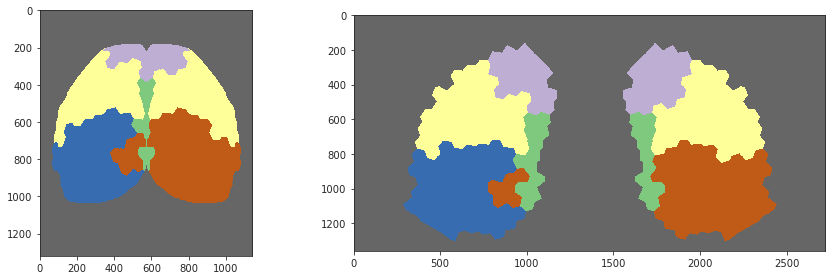

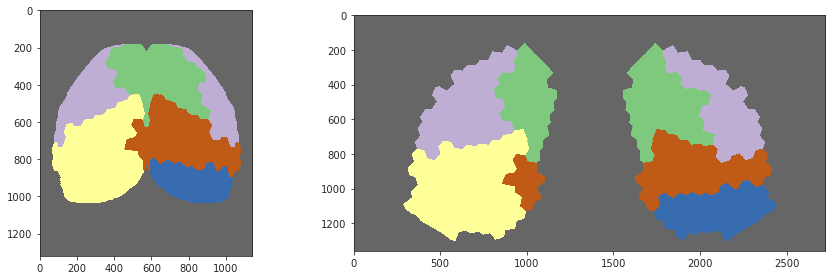

In [20]:
fig, axes = create_figure(1, 2, (13, 4))
axes[0].imshow(proj_pears_bold['parcel2d-top'].squeeze(), cmap='Accent_r')
axes[1].imshow(proj_pears_bold['parcel2d-flat'].squeeze(), cmap='Accent_r')
plt.show()

fig, axes = create_figure(1, 2, (13, 4))
axes[0].imshow(proj_spear_bold['parcel2d-top'].squeeze(), cmap='Accent_r')
axes[1].imshow(proj_spear_bold['parcel2d-flat'].squeeze(), cmap='Accent_r')
plt.show()

In [39]:
num_nans = {}
adj_all = []
for key, func in tqdm(mice.bold.items()):
    if mice.looper[key][-1] < 0:
        continue
        
    base = Base(mice, key=key, mode='bold-lite')
    a, p = sp_stats.spearmanr(base.data, axis=1)
    a[p > 0.05] = np.nan
    adj_all.append(np.expand_dims(a, 0))
    
    num_nans[key] = (np.isnan(a).sum(0) == len(a)).sum()
    

adj_all = np.concatenate(adj_all)
adj_all = bn.nanmean(adj_all, 0)

for i in range(len(adj_all)):
    nans = np.isnan(adj_all[i])
    adj_all[i][nans] = bn.nanmean(adj_all[i])
    
a_sym = (adj_all + adj_all.T) / 2
d = 1 - a_sym

  0%|          | 0/160 [00:00<?, ?it/s]

In [50]:
z = sp_hier.linkage(
    sp_dist.squareform(d),
    method='ward',
    metric='correlation',
    optimal_ordering=True,
)
result = get_clust_graph(
    linkage_mat=z,
    labels=base.l2n,
    num_clusters=5,
)
comm_vec = np.zeros(len(base.n2l))
for c_idx, clist in result['cluster_assigns'].items():
    for lbl in clist:
        comm_vec[base.l2n[lbl]] = c_idx

In [51]:
proj = base.project_vec(comm_vec)

<matplotlib.image.AxesImage object at 0x7f571c6b0fa0>

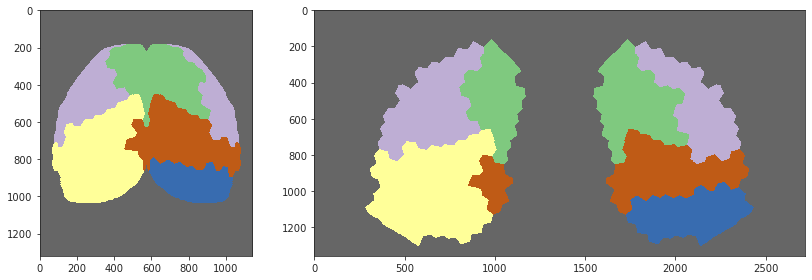

In [52]:
fig, axes = create_figure(1, 2, (13, 4))
axes[0].imshow(proj['parcel2d-top'].squeeze(), cmap='Accent_r')
axes[1].imshow(proj['parcel2d-flat'].squeeze(), cmap='Accent_r')

In [55]:
from nancorrmp.nancorrmp import NaNCorrMp

In [57]:
num_nans = {}
adj_all = []
for key, func in tqdm(mice.bold.items()):
    if mice.looper[key][-1] < 0:
        continue
        
    base = Base(mice, key=key, mode='bold-lite')
    a, p = NaNCorrMp.calculate_with_p_value(base.data)
    a[p > 0.05] = np.nan
    adj_all.append(np.expand_dims(a, 0))
    
    num_nans[key] = (np.isnan(a).sum(0) == len(a)).sum()
    

adj_all = np.concatenate(adj_all)
adj_all = bn.nanmean(adj_all, 0)

for i in range(len(adj_all)):
    nans = np.isnan(adj_all[i])
    adj_all[i][nans] = bn.nanmean(adj_all[i])
    
a_sym = (adj_all + adj_all.T) / 2
d = 1 - a_sym

  0%|          | 0/160 [00:00<?, ?it/s]

<matplotlib.image.AxesImage object at 0x7f571c6a13d0>

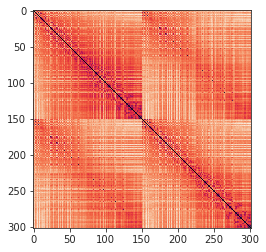

In [58]:
plt.imshow(d)

In [65]:
z = sp_hier.linkage(
    sp_dist.squareform(d),
    method='ward',
    metric='correlation',
    optimal_ordering=True,
)
result = get_clust_graph(
    linkage_mat=z,
    labels=base.l2n,
    num_clusters=5,
)
comm_vec = np.zeros(len(base.n2l))
for c_idx, clist in result['cluster_assigns'].items():
    for lbl in clist:
        comm_vec[base.l2n[lbl]] = c_idx

In [66]:
proj = base.project_vec(comm_vec)

<matplotlib.image.AxesImage object at 0x7f571503ba00>

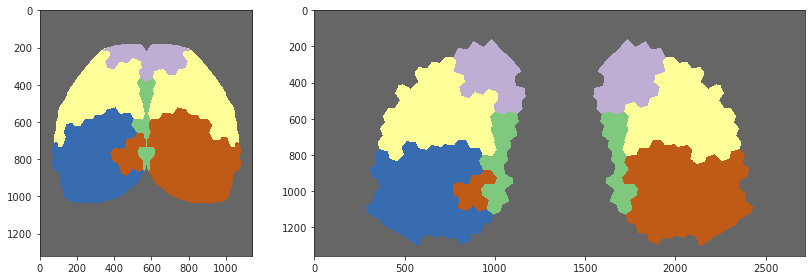

In [67]:
fig, axes = create_figure(1, 2, (13, 4))
axes[0].imshow(proj['parcel2d-top'].squeeze(), cmap='Accent_r')
axes[1].imshow(proj['parcel2d-flat'].squeeze(), cmap='Accent_r')

## Hier Ca

In [3]:
%%time

hier = Hierarchical(
    mice=mice, key='sub-SLC', mode='ca2', task='rest',
).fit_hierarchical(range(3, 11))

CPU times: user 10.4 s, sys: 12.7 s, total: 23.1 s
Wall time: 4min 55s


In [4]:
pi_disjoint = np.zeros((len(hier.results), len(hier.n2l)), dtype='uint32')

for i, (n_clust, result_d) in enumerate(hier.results.items()):
    for oc_idx, clist in result_d['cluster_assigns'].items():
        for lbl in clist:
            node = hier.l2n[lbl]
            pi_disjoint[i, node] = oc_idx
            
proj = hier.project_vec(pi_disjoint)

In [6]:
import ants

topview = 'topview_10um.nii.gz'
topview = pjoin(mice.cfg.base_dir, topview)
topview = ants.image_read(topview, pixeltype='unsigned int')
topview = topview.numpy()

flatmap = 'flatmap_10um.nii.gz'
flatmap = pjoin(mice.cfg.base_dir, flatmap)
flatmap = ants.image_read(flatmap, pixeltype='unsigned int')
flatmap = flatmap.numpy()

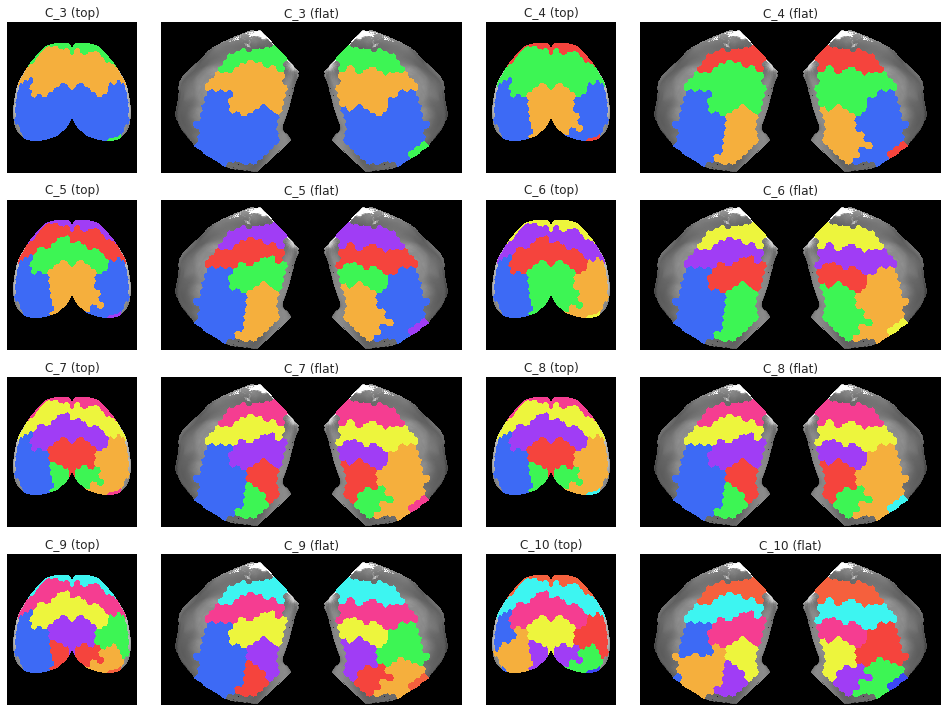

In [7]:
ncols = 4
nrows = int(np.ceil(len(hier.results) / (ncols / 2)))
fig, axes = create_figure(nrows, ncols, (13.5, 2.5 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 2]})

min_thres = 0.1

for i, n_clust in enumerate(hier.results):
    cmap = get_cluster_cmap(range(n_clust))
    data_top = proj['parcel2d-top'][i]
    data_flat = proj['parcel2d-flat'][i]

    data2plt = np.ma.masked_where(data_top < min_thres, data_top)
    ax = axes.ravel()[i * 2]
    ax.imshow(topview, cmap='Greys_r')
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(f"C_{n_clust} (top)")

    data2plt = np.ma.masked_where(data_flat < min_thres, data_flat)
    ax = axes.ravel()[i * 2 + 1]
    ax.imshow(flatmap, cmap='Greys_r')
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(f"C_{n_clust} (flat)")

trim_axs(axes, 2 * len(hier.results))
remove_ticks(axes)
plt.show()

In [29]:
props = {'mice': mice, 'mode': 'ca2', 'task': 'led'}

In [30]:
%%time

hier = Hierarchical(
    key='sub-SLC', **props,
).fit_hierarchical(range(3, 11))

CPU times: user 10.2 s, sys: 15.6 s, total: 25.8 s
Wall time: 3min 28s


In [31]:
pi_disjoint = np.zeros((len(hier.results), len(hier.n2l)), dtype='uint32')

for i, (n_clust, result_d) in enumerate(hier.results.items()):
    for oc_idx, clist in result_d['cluster_assigns'].items():
        for lbl in clist:
            node = hier.l2n[lbl]
            pi_disjoint[i, node] = oc_idx
            
proj = hier.project_vec(pi_disjoint)

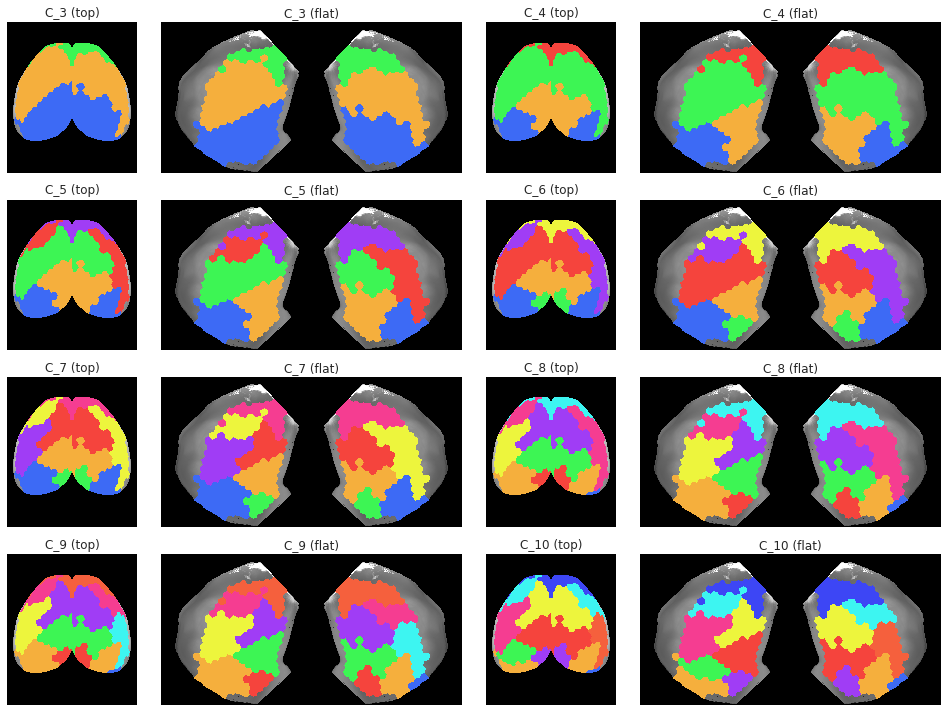

In [32]:
ncols = 4
nrows = int(np.ceil(len(hier.results) / (ncols / 2)))
fig, axes = create_figure(nrows, ncols, (13.5, 2.5 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 2]})

min_thres = 0.1

for i, n_clust in enumerate(hier.results):
    cmap = get_cluster_cmap(range(n_clust))
    data_top = proj['parcel2d-top'][i]
    data_flat = proj['parcel2d-flat'][i]

    data2plt = np.ma.masked_where(data_top < min_thres, data_top)
    ax = axes.ravel()[i * 2]
    ax.imshow(topview, cmap='Greys_r')
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(f"C_{n_clust} (top)")

    data2plt = np.ma.masked_where(data_flat < min_thres, data_flat)
    ax = axes.ravel()[i * 2 + 1]
    ax.imshow(flatmap, cmap='Greys_r')
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(f"C_{n_clust} (flat)")

trim_axs(axes, 2 * len(hier.results))
remove_ticks(axes)
plt.show()

In [7]:
import ants

topview = 'topview_10um.nii.gz'
topview = pjoin(mice.cfg.base_dir, topview)
topview = ants.image_read(topview, pixeltype='unsigned int')
topview = topview.numpy()

flatmap = 'flatmap_10um.nii.gz'
flatmap = pjoin(mice.cfg.base_dir, flatmap)
flatmap = ants.image_read(flatmap, pixeltype='unsigned int')
flatmap = flatmap.numpy()

In [6]:
def project_vec(
        self,
        vec: np.ndarray,
        min_thres: float = 0.01, ):
    if self.mode == 'ca2':
        items = [
            'parcel2d-top',
            'parcel2d-flat',
        ]
    else:
        items = ['parcel3d']
    shapes = {
        name: self.mice.parcel[f"shape_{name}"]
        for name in items
    }
    proj = {
        name: np.zeros((len(vec), *sh), dtype=float)
        for name, sh in shapes.items()
    }
    for i, data in enumerate(vec):
        for node, lbl in self.n2l.items():
            if data[node] < min_thres:
                continue
            ii = self.mice.parcel.encode(lbl)
            for name, arr in proj.items():
                reg_k = f"region-idxs_{name}"
                nonzero_k = f"nonzero-idxs_{name}"
                if ii in self.mice.parcel[reg_k]:
                    ids = self.mice.parcel[reg_k][ii]
                    ids = self.mice.parcel[nonzero_k][ids]
                    arr[i].flat[ids] = data[node]
    return proj

In [12]:
proj = project_vec(pi_disjoint, hier.n2l)

  0%|          | 0/8 [00:00<?, ?it/s]

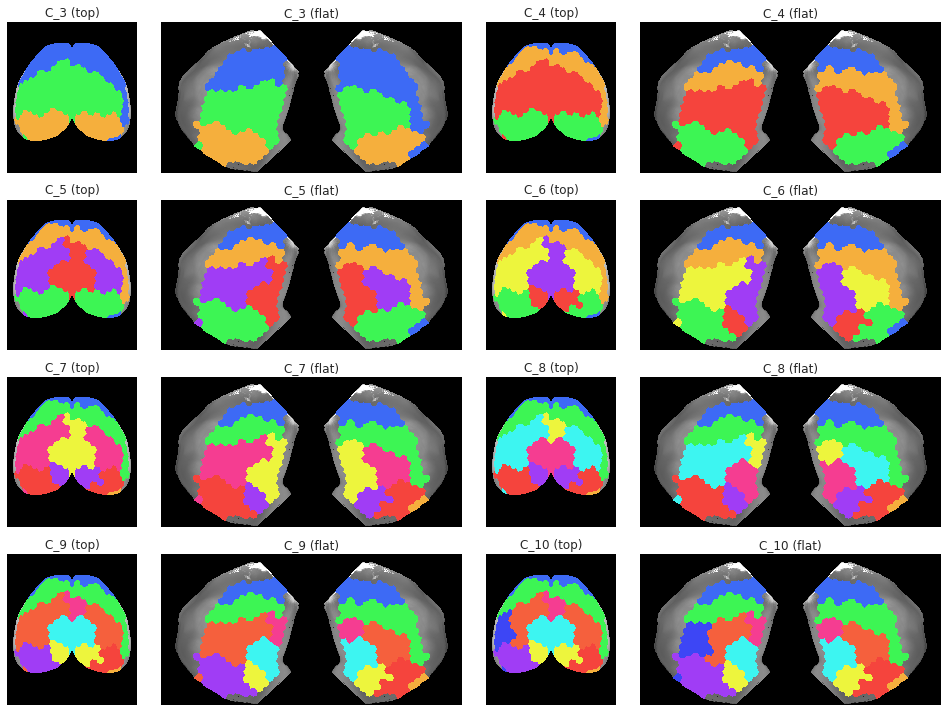

## Hier BOLD

In [ ]:
%%time

net_ca = Network(
    mice=mice,
    key='sub-SLC',
    df=mice.ca_dfs['sub-SLC'],
    percentiles=np.linspace(50, 1, 50),
).fit_network(save=False)

In [ ]:
%%time

net_bold = Network(
    mice=mice,
    key='sub-SLC',
    df=mice.bold_dfs['sub-SLC'],
    percentiles=np.linspace(50, 1, 50),
).fit_network(save=False)

In [ ]:
sns.histplot(net_ca.adj[net_ca.adj.nonzero()], color='C0', alpha=0.5, stat='density')
plt.axvline(net_ca.thresholds[10], color='g', ls='--')
plt.axvline(net_ca.thresholds[5], color='r', ls='--')

sns.histplot(net_bold.adj[net_bold.adj.nonzero()], color='C1', alpha=0.5, stat='density')
plt.axvline(net_bold.thresholds[10], color='g', ls=':')
plt.axvline(net_bold.thresholds[5], color='r', ls=':')

plt.show()

In [ ]:
x = mice.ca_dfs['sub-SLC'].values
x.shape

In [ ]:
nans = np.where(np.isnan(x).sum(0) > 0)[0]
x = np.delete(x, nans, axis=1)
x.shape

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(
    n_components=100,
    svd_solver='full',
).fit(x)

In [ ]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
pca.components_.shape

In [ ]:
y = pca.transform(x)
y.shape

In [ ]:
plt.plot(y[:, 0])

In [ ]:
np.where(y[:, 0] > 100)[0]

In [ ]:
i = 21999
plt.imshow(x[i-150:i+150].T)

In [ ]:
i = 21999
plt.imshow(x[i-10:i+10].T, aspect=0.2)
plt.colorbar()

In [ ]:
plt.plot(np.abs(x).mean(-1))

In [ ]:
z = y.copy()
z[:, 0] = 0

x_inv = pca.inverse_transform(z)
x_inv.shape

In [ ]:
df_new = pd.DataFrame(x_inv)
df_new.shape

In [ ]:
a, p = get_adj_mat(df_new, 'pearson')

In [ ]:
plt.imshow(a)
plt.colorbar()

In [ ]:
plt.imshow(net_ca.adj)
plt.colorbar()

In [ ]:
sns.histplot(net_ca.adj[net_ca.adj.nonzero()], color='C0', alpha=0.5, stat='density')
plt.axvline(net_ca.thresholds[10], color='g', ls='--')
plt.axvline(net_ca.thresholds[5], color='r', ls='--')

sns.histplot(a[a.nonzero()], color='C5', alpha=0.5, stat='density')
plt.axvline(net_ca.thresholds[10], color='g', ls='--')
plt.axvline(net_ca.thresholds[5], color='r', ls='--')

In [ ]:
plt.imshow(a)
plt.colorbar()

In [ ]:
th = np.quantile(a.ravel(), q=0.8)

a_gsr = a.copy()
a_gsr[a > th] = 1.0
a_gsr[a <= th] = 0.0

In [ ]:
th = np.quantile(net_ca.adj.ravel(), q=0.8)

a_full = net_ca.adj.copy()
a_full[net_ca.adj > th] = 1.0
a_full[net_ca.adj <= th] = 0.0

In [ ]:
plt.imshow(a_gsr)

In [ ]:
plt.imshow(a_full)

In [ ]:
a_full2 = np.delete(np.delete(a_full, nans, axis=0), nans, axis=1)

In [ ]:
plt.imshow(a_full2)

In [ ]:
df = mice.ca_dfs['sub-SLC'].copy()
df[df.isnull()] = 0

In [ ]:
df

In [ ]:
hier = Hierarchical(mice, 'sub-SLC', df)

In [ ]:
hier.fit(5)

In [ ]:
_ = hier.fit(7)

In [ ]:
hier.results[7]['cluster_assigns']

In [ ]:
"""cluster_assigns = hier.results[5]['cluster_assigns']
cluster_assigns = {
    c_idx: [
        mice.parcel.encode(*tuple(map(
            lambda string: int(string),
            net_ca.n2l[e].split('-'))))
        for e in c_list]
    for c_idx, c_list in cluster_assigns.items()
}
cluster_assigns"""

In [ ]:
_ = hier.fit(7)

In [ ]:
results = get_pdist(, 'correlation')

In [ ]:
list(results)

In [ ]:
results['y']

In [ ]:
x = mice.ca_dfs['sub-SLC01_ses-1_run-1'].values
x = np.ma.masked_where(~np.isfinite(x), x)
x.shape

In [ ]:
y = sp_dist.pdist(x.T, metric='correlation')

In [ ]:
y, len(y)

In [ ]:
from nancorrmp.nancorrmp import NaNCorrMp

In [ ]:
mice.ca_dfs['sub-SLC01_ses-1_run-1'].reset_index(drop=True).to_dict().items()

In [ ]:
a = NaNCorrMp.calculate,(x)

In [ ]:
a.shape

In [ ]:
plt.imshow(a)

In [ ]:
from analysis.hierarchical import sp_hier


In [ ]:
yy = results['y'].copy()
yy = np.ma.masked_where(~np.isfinite(yy), yy)
sp_hier.linkage(yy)

In [ ]:
y = results['y'].copy()
np.isfinite(y)

In [ ]:
sp_hier.linkage(np.random.randn(10))

In [ ]:
net.thresholds

In [ ]:
plt.imshow(net.adjacencies[31], cmap=net.style['cmap'])
plt.colorbar()

In [ ]:
list(net.adjacencies)

In [ ]:
x = net.adjacencies[10].copy()
x[x.nonzero()] = 1
plt.imshow(x, cmap=net.style['cmap'])
plt.show()

In [ ]:
plt.imshow(net.adjacencies[10], cmap=net.style['cmap'])
plt.show()

In [ ]:
plt.imshow(net.adjacencies[10], cmap=net.style['cmap'])
plt.show()

In [ ]:
list(net.l2n)[:15]

In [ ]:
plt.imshow(net.adjacencies[10][:15][:, :15], cmap=net.style['cmap'])
plt.show()

In [ ]:
net.set_percentiles(np.linspace(39, 1, 39), fit=False)

In [ ]:
net._apply_thresholds()

In [ ]:
net.thresholds

In [ ]:
sns.histplot(net.adj[net.adj.nonzero()], color='C0')
plt.axvline(net.thresholds[10], color='g', ls='--')
plt.axvline(net.thresholds[5], color='r', ls='--')

In [ ]:
x = net.adjacencies[25].copy()
x[x.nonzero()] = 1
plt.imshow(x, cmap=net.style['cmap'])
plt.show()

In [ ]:
df_stim = mice.load_stim_times('ca2')
df_stim

In [ ]:
_df = df_stim.loc[df_stim['stim'] == 1]
_df = _df[_df['task'].values == 'rest']
_df

In [ ]:
_df['key'].unique()

In [ ]:
df_stim = mice.load_stim_times('bold')
df_stim

In [ ]:
save_obj(dfs, 'test_ca', tmp_dir, 'npy')

In [ ]:
list(dfs)

In [ ]:
dfs['sub-SLC08_ses-2_run-6']

In [ ]:
x = dfs['sub-SLC08_ses-2_run-6'].corr()
x = x.values
np.fill_diagonal(x, 0.)

In [ ]:
plt.imshow(x)

In [ ]:
x.shape

In [ ]:
a, p = get_adj_mat(dfs['sub-SLC08_ses-2_run-6'], 'pearson')
aa, pp = get_adj_mat(dfs['sub-SLC08_ses-2_run-6'], 'spearman')

In [ ]:
idxs_pears = np.where(np.abs(a).sum(0) == 0)[0]
idxs_spear = np.where(np.abs(aa).sum(0) == 0)[0]

In [ ]:
a.shape, aa.shape

In [ ]:
fig, axes = create_figure(1, 2, (12, 4.5))

vminmax = np.max(np.abs(a))
im = axes[0].imshow(a, cmap='bwr', vmin=-vminmax, vmax=vminmax)
plt.colorbar(im, ax=axes[0])

vminmax = np.max(np.abs(aa))
im = axes[1].imshow(aa, cmap='bwr', vmin=-vminmax, vmax=vminmax)
plt.colorbar(im, ax=axes[1])

In [ ]:
sns.histplot(a[a.nonzero()], color='C0', alpha=0.5)
sns.histplot(aa[aa.nonzero()], color='C1', alpha=0.5)

In [ ]:
node_labels = dfs['sub-SLC08_ses-2_run-6'].columns.values

In [ ]:
node_labels

In [ ]:
n2l = {i: lbl for i, lbl in enumerate(node_labels)}
l2n = {lbl: i for i, lbl in n2l.items()}

In [ ]:
n2l

In [ ]:
dfs = mice.make_dfs('ca2')

In [ ]:
y = dfs['sub-SLC08_ses-2_run-6'].corr()
y = y.values
np.fill_diagonal(y, 0.)

In [ ]:
plt.imshow(y)

In [ ]:
np.isnan(y).sum(1)

In [ ]:
aaa = np.where(np.isnan(y).sum(1) > 100)[0]
aaa

In [ ]:
bbb = dfs['sub-SLC08_ses-2_run-6'].columns[aaa]
bbb

In [ ]:
ca_func = mice.ca['sub-SLC08_ses-2_run-6'].get_data()

In [ ]:
{k: v for k, v in ca_func.items() if k in bbb}

In [ ]:
sns.histplot(perc_missing.values())

In [ ]:
mice.setup_func_data()

In [ ]:
x = mice.ca['sub-SLC01_ses-2_run-3'].get_data()

In [ ]:
list(x)

In [ ]:
def _reindex_fn(s):
    vals = tuple(map(lambda e: int(e), s.split('-')))
    i = int(vals[0] * 2e9) + vals[-1]
    if len(vals) == 3:
        i += int(vals[1] * 10)
    return i + int(6e6 / len(vals))

In [ ]:
sorted(x, key=_reindex_fn)

In [ ]:
from register.register import Register
reg = Register(mice)

In [ ]:
reg.organize_func(0.1)

In [ ]:
reg.set_mode('3d')
acc = reg.get_accepted_regions(0.1)
{k: len(v) for k, v in acc.items()}

In [ ]:
cor3d = acc['cortex-merged']

In [ ]:
reg.set_mode('2d')
acc2 = reg.get_accepted_regions(0.1)
{k: len(v) for k, v in acc2.items()}

cor2d = acc2['cortex-merged']

In [ ]:
[i for i in cor2d if i not in cor3d]

In [ ]:
thres = 0.1

regions_all = {}
for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        mask = mice.mask3d[key].load_ants('unsigned int')
        mask = mask.numpy().astype(bool)
        obj = reg.load_obj_masks(key)
        x = obj['cortex-merged'].numpy()
        x *= mask
        regions = np.unique(x[x.nonzero()])
        regions_all[key] = sorted(regions)

regions_agg = []
for item in regions_all.values():
    regions_agg += item
freq = collections.Counter(regions_agg)
freq = {
    i: v / len(regions_all)
    for i, v in freq.items()
}
freq = {
    i: freq.get(i, 0.0) for i in
    mice.parcel.complement(list(freq))
}

rej = dict(filter(
    lambda t: t[1] < thres,
    freq.items()
))
rej = mice.parcel.complement(sorted(rej))
acc = [
    i for i in freq
    if i not in rej
]

msg = '\n\n'
msg += f"Name: {'cortex-merged'} . . . a total of {len(acc)} regions were accepted.\n"
msg += f"accept ratio: {100 * len(acc) / len(freq):0.0f} %, "
msg += f"reject ratio: {100 * len(rej) / len(freq):0.0f} %, "
msg += f"using a presence threshold of {0.1 * 100} %\n"

print(msg)

In [ ]:
sns.ecdfplot(freq.values())

In [ ]:

list(obj)

In [ ]:
regions_all = {}


In [ ]:
mice.parcel.fit_parcel(True, cutoff=3)

In [ ]:
from register.register import Register
reg = Register(mice)

In [ ]:
reg.register_anat(True)

In [ ]:
reg.organize_func()

In [ ]:
path = '/home/hadi/Documents/workspaces/allen/MouseConnectivity/cortical_coordinates'
sorted(os.listdir(path))

In [ ]:
laplacian, laplacian_header = nrrd.read(pjoin(path, 'laplacian_10.nrrd'))

In [ ]:
laplacian.shape

In [ ]:
laplacian_header

In [ ]:
plt.imshow(laplacian[600], cmap='turbo')

In [ ]:
boundary, boundary_header = nrrd.read(pjoin(path, 'isocortex_boundary_10.nrrd'))

In [ ]:
import h5py

In [ ]:
with h5py.File(pjoin(path, 'top_view_paths_10.h5'), 'r') as f:
    paths = np.array(f['paths'])
    view = np.array(f['view lookup'])
paths.shape, view.shape

In [ ]:
plt.imshow(view)
plt.colorbar()

In [ ]:
with h5py.File(pjoin(path, 'dorsal_flatmap_paths_10.h5'), 'r') as f:
    dorsal_paths = np.array(f['paths'])
    dorsal_view = np.array(f['view lookup'])
dorsal_paths.shape, dorsal_view.shape

In [ ]:
plt.imshow(dorsal_view)